Tải bộ dữ liệu WELFake

In [1]:
!gdown 1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3

Downloading...
From (original): https://drive.google.com/uc?id=1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3
From (redirected): https://drive.google.com/uc?id=1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3&confirm=t&uuid=1db8c453-98b0-4076-9814-1fb47dd8b764
To: /content/WELFake_Dataset.csv
100% 245M/245M [00:02<00:00, 108MB/s]


In [2]:
import re
import nltk
import tensorflow
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

Xóa các kí tự null và nối cột title vào cột test

In [3]:
df = pd.read_csv("/content/WELFake_Dataset.csv")
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Thực hiện tăng cường dữ liệu bằng cách thay thế từ đồng nghĩa (SR)

In [5]:
import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
corpus = []

def replace_synonyms(text):
    words = word_tokenize(text)
    replaced_text = []

    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            replaced_text.append(synonym.replace('_', ' '))
        else:
            replaced_text.append(word)

    return ' '.join(replaced_text)

def remove_function_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words]

    return ' '.join(filtered_text)

def preprocess_txt(text, use_synonyms=False, use_fwd=False):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    if use_synonyms:
        text = replace_synonyms(text)

    if use_fwd:
        text = remove_function_words(text)

    tokens = word_tokenize(text)

    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    unique_tokens = []
    for token in tokens:
        if token not in unique_tokens:
            unique_tokens.append(token)

    preprocessed_text = ' '.join(unique_tokens)
    corpus.append(preprocessed_text)
    return preprocessed_text

df['preprocessed_text'] = df['text'].apply(lambda x: preprocess_txt(x, use_synonyms=True, use_fwd=False) if isinstance(x, str) else "")

In [6]:
df.head()

,Unnamed: 0,title,text,label,preprocessed_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,law enforc on high alert follow menac against ...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,incred obama lawyer gener say most charlott ri...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story of Chri...",0,bobbi jindal rais hindu use narr of christian ...
4,4,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis an image of its terrif...,1,satan soviet union unv associ in nurs imag of ...
5,5,About Time! Christian Group Sues Amazon and SP...,About Time! Christian Group Sues Amazon and SP...,1,about time christian group sue amazon and splc...


Thực hiện one-hot encoding

In [7]:
vocab_size = 10000

onehot=[one_hot(words,vocab_size)for words in corpus]

In [8]:
sent_length = 500
padded_onehot = pad_sequences(onehot, padding='post',maxlen=sent_length)
print(padded_onehot)

[[8129 8268  600 ...    0    0    0]
 [6370 8528 3189 ...    0    0    0]
 [8523 6098 1737 ... 2814 8422 6100]
 ...
 [8579 4782 9076 ...    0    0    0]
 [1425 2475 2073 ...    0    0    0]
 [5398 2440 3963 ...    0    0    0]]


In [9]:
padded_data = np.array(padded_onehot)
label = np.array(df['label'])

print(padded_data.shape)
print(label.shape)

(71537, 500)
(71537,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(padded_onehot, label, test_size=0.2, random_state=42)
print(f"training data shape {X_train.shape}")
print(f"testing data shape {X_test.shape}")

training data shape (57229, 500)
testing data shape (14308, 500)


Xây dựng mô hình

In [11]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Huấn luyện mô hình 

In [12]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_train, y_train),
    epochs=10,
    batch_size=64
)

Epoch 1/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.5114 - loss: 0.6913 - val_accuracy: 0.5397 - val_loss: 0.6704
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.5333 - loss: 0.6703 - val_accuracy: 0.5470 - val_loss: 0.6607
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.5421 - loss: 0.6569 - val_accuracy: 0.5513 - val_loss: 0.6466
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.5536 - loss: 0.6380 - val_accuracy: 0.8574 - val_loss: 0.3401
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.8798 - loss: 0.2965 - val_accuracy: 0.9309 - val_loss: 0.2044
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9341 - loss: 0.1855 - val_accuracy: 0.9545 - val_loss: 0.1299
Epoch 7/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9610 - loss: 0.1129 - val_accuracy: 0.9828 - val_loss: 0.0532
Epoch 8/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9815 - loss: 0.0580 - 

Vẽ đồ thị học accuracy và loss

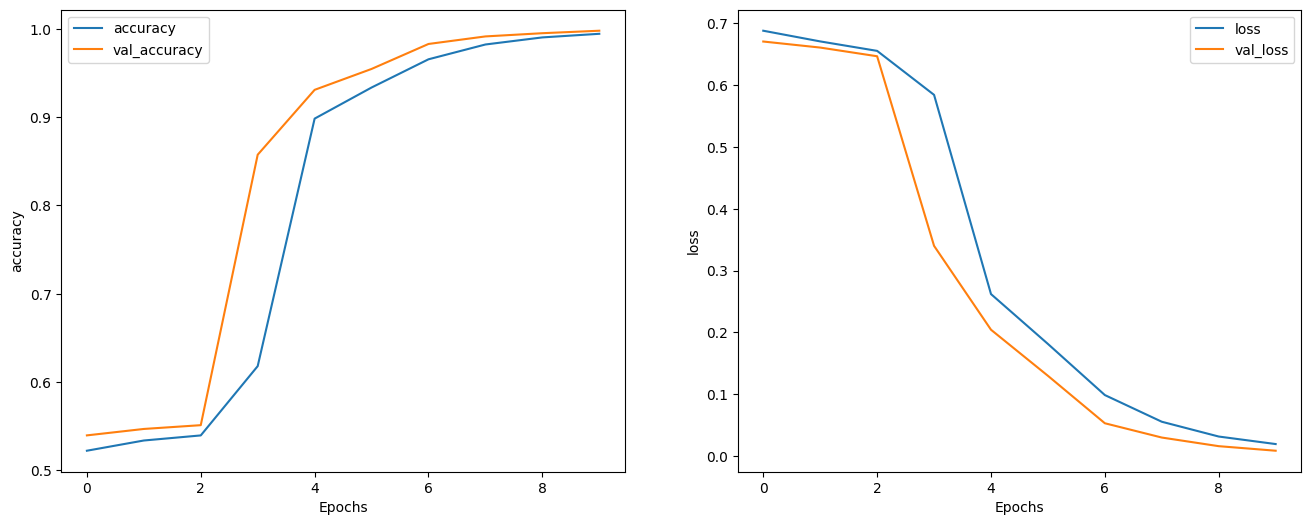

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Đánh giá mô hình 

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.6, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Accuracy: 0.9688286273413474


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7081
           1       0.97      0.97      0.97      7227

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308



Vẽ ma trận nhầm lẫn 

Text(70.72222222222221, 0.5, 'Real Labels')

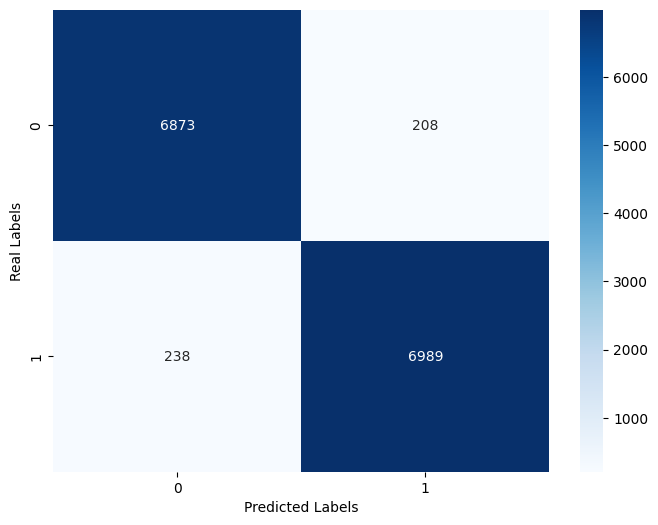

In [16]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

conf_matrix = confusion_matrix(y_test,y_pred)

true_negatives = conf_matrix[0][0]
false_positives = conf_matrix[0][1]
false_negatives = conf_matrix[1][0]
true_positives = conf_matrix[1][1]

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Precision: 0.9711
Recall: 0.9671
F1-score: 0.9691
Accuracy: 0.9688
